### Preliminaries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import torch
from torch import nn 
import torch.nn.functional as F
from torch import optim
from torch.autograd import grad
from scipy.io import loadmat

from argparse import Namespace
from functools import reduce
import seaborn as sns
import pickle

import pandas as pd
from matplotlib.colors import LogNorm, Normalize

from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/229 Project'

MessageError: ignored

In [ ]:
# install DeepXDE
%pip install deepxde

In [ ]:
# import packages
from deepxde.backend.set_default_backend import set_default_backend
set_default_backend("tensorflow.compat.v1")

import deepxde as dde
import numpy as np

from deepxde.backend import tf

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import random

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Fourier Helper Functions

In [ ]:
def get_fft(y, sampling_rate):
  # Calculate the Fourier transform of f(x)
  fourier = np.fft.fft(y.squeeze())

  length = len(y)

  # Calculate the corresponding frequencies
  freq = np.fft.fftfreq(length, 1/sampling_rate)

  results = list(zip(freq, np.abs(fourier)))
  filtered = [(x, y) for (x, y) in results if x > 0]
  results = list(zip(*filtered))

  return results

### Computing the Wasserstein Distance

In [ ]:
def wasserstein_dist(first_amps, second_amps):
  first_amps = first_amps/sum(first_amps)
  second_amps = second_amps/sum(second_amps)

  first_cdf = np.cumsum(first_amps)
  second_cdf = np.cumsum(second_amps)

  return sum(abs(first_cdf - second_cdf))/len(first_cdf) + 1e-3

In [ ]:
def get_pairwise_dists(solution, domain_len, num_x):
  results = {"time_one": [], "time_two": [], "value": []}

  for t_1 in np.linspace(0, 0.99, 100):
      for t_2 in np.linspace(0, 0.99, 100):
        start_1 = int(num_x * t_1 * 100)
        end_1 = start_1 + num_x

        start_2 = int(num_x * t_2 * 100)
        end_2 = start_2 + num_x

        _, fourier_1 = get_fft(solution[start_1:end_1], num_x/domain_len)
        _, fourier_2 = get_fft(solution[start_2:end_2], num_x/domain_len)

        results['time_one'].append(t_1)
        results['time_two'].append(t_2)
        results['value'].append(wasserstein_dist(fourier_1, fourier_2))

  return results

In [ ]:
def plot_wasserstein(true_sol, pred_sol, domain_len, num_x=256):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 8))

    true_dict = get_pairwise_dists(true_sol, domain_len, num_x)
    pred_dict = get_pairwise_dists(pred_sol, domain_len, num_x)

    true_dists = pd.DataFrame(data = true_dict)
    true_dists = true_dists.round(3)
    true_dists = true_dists.pivot("time_one", "time_two", "value")
    sns.heatmap(true_dists, yticklabels=3, xticklabels=10, norm=LogNorm(), cbar_kws={'label': 'Wasserstein Distance between Spectra'}, ax=ax0, cmap="BuPu")
    ax0.invert_yaxis()
    ax0.set_xlabel("Time")
    ax0.set_ylabel("Time")
    ax0.set_title(f"Analyzing Spectrum Evolution of True Solution")

    pred_dists = pd.DataFrame(data = pred_dict)
    pred_dists = pred_dists.round(3)
    pred_dists = pred_dists.pivot("time_one", "time_two", "value")
    sns.heatmap(pred_dists, yticklabels=3, xticklabels=10, norm=LogNorm(), cbar_kws={'label': 'Wasserstein Distance between Spectra'}, ax=ax1, cmap="BuPu")
    ax1.invert_yaxis()
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Time")
    ax1.set_title(f"Analyzing Spectrum Evolution of Predicted Solution")
    plt.show()


    diff_dists = abs(true_dists.sub(pred_dists))
    sns.heatmap(diff_dists, yticklabels=3, xticklabels=10, norm=LogNorm(), cbar_kws={'label': 'Wasserstein Distance between Spectra'}, cmap="BuPu")
    plt.xlabel("Time")
    plt.ylabel("Time")
    plt.title(f"Difference in Wasserstein Distances b/w True and Predicted")
    plt.gca().invert_yaxis()
    plt.show()

### Burgers' Equation

#### Generating True Solution

In [ ]:
# import data for the true solution
def gen_testdata():
    data = np.load("Burgers.npz")
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y

In [ ]:
# compare the true solution with the predicted solution
X, y_true = gen_testdata()
y_true = y_true.squeeze()

# with open('model_preds_full_domain.pkl', 'rb') as f:
#     all_preds = pickle.load(f)

with open('model_preds.pkl', 'rb') as f:
    all_preds = pickle.load(f)

#### Plotting Wasserstein Distance

<ipython-input-8-8538fd482480>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  true_dists = true_dists.pivot("time_one", "time_two", "value")
<ipython-input-8-8538fd482480>:18: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pred_dists = pred_dists.pivot("time_one", "time_two", "value")


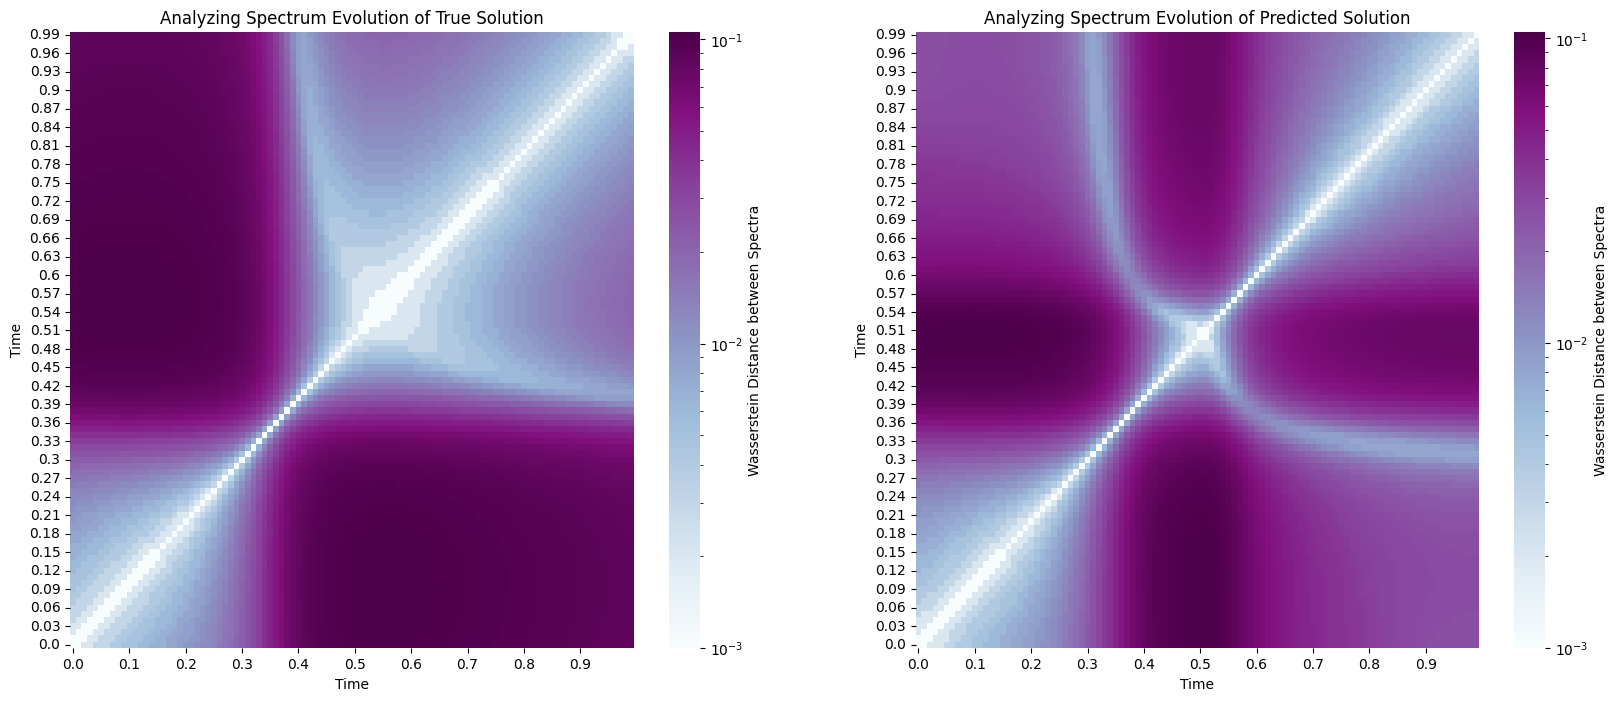

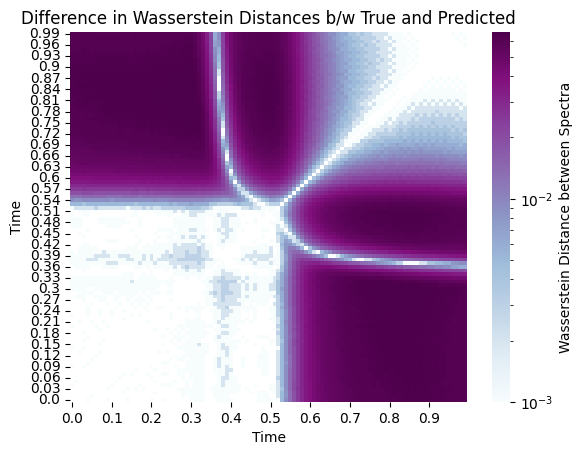

In [ ]:
plot_wasserstein(y_true, all_preds[50000], domain_len=2, num_x=256)

### Allen-Cahn Equation

#### Generating True Solution

In [ ]:
def gen_testdata():
    data = loadmat("Allen_Cahn.mat")

    t = data["t"]
    x = data["x"]
    u = data["u"]

    dt = dx = 0.01
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = u.flatten()[:, None]
    return X, y

In [ ]:
X, y_true = gen_testdata()
y_true = y_true.squeeze()

with open('model_preds_allen_cahn.pkl', 'rb') as f:
    all_preds = pickle.load(f)

#### Plotting Wasserstein Distance

<ipython-input-21-e3a92bde810f>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  true_dists = true_dists.pivot("time_one", "time_two", "value")
<ipython-input-21-e3a92bde810f>:18: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pred_dists = pred_dists.pivot("time_one", "time_two", "value")


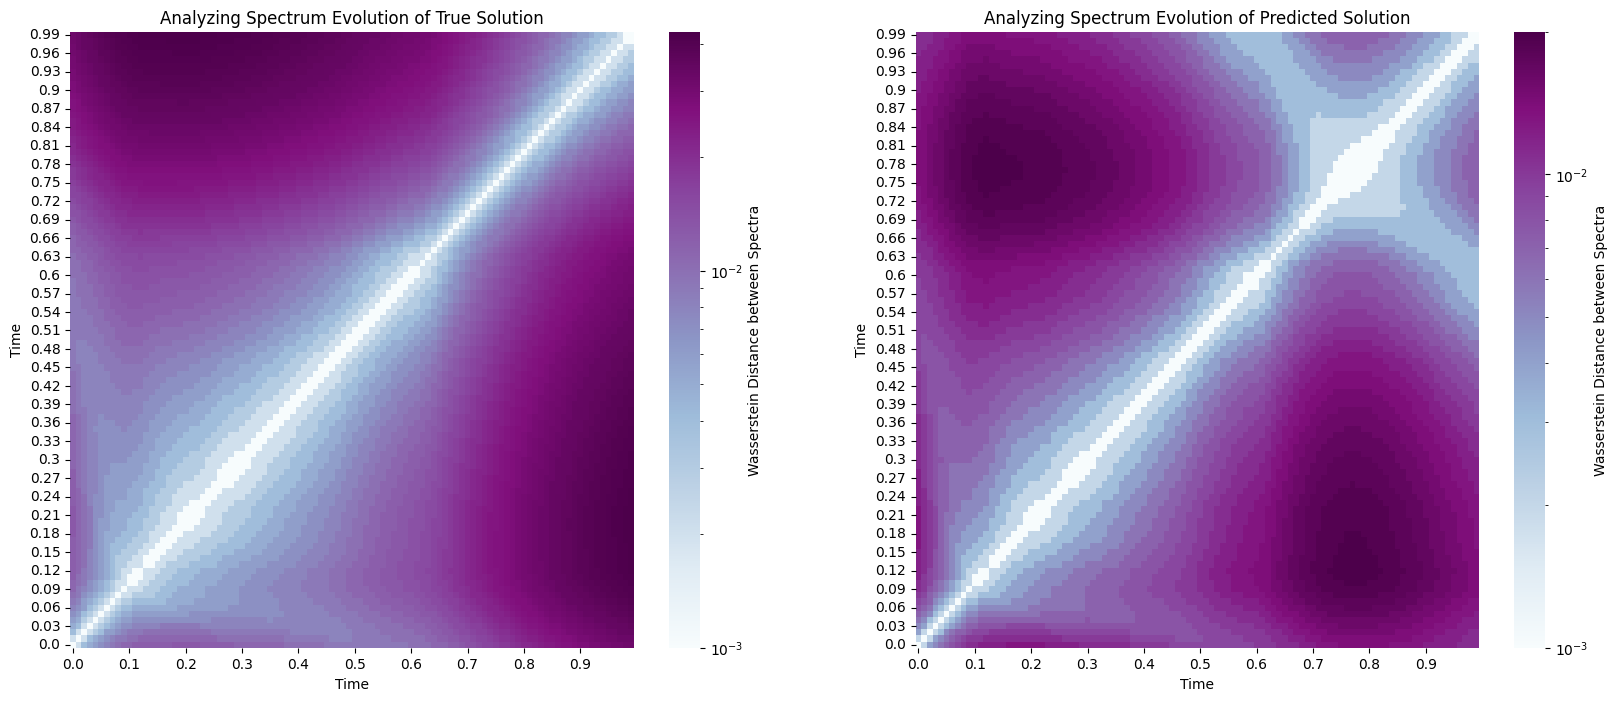

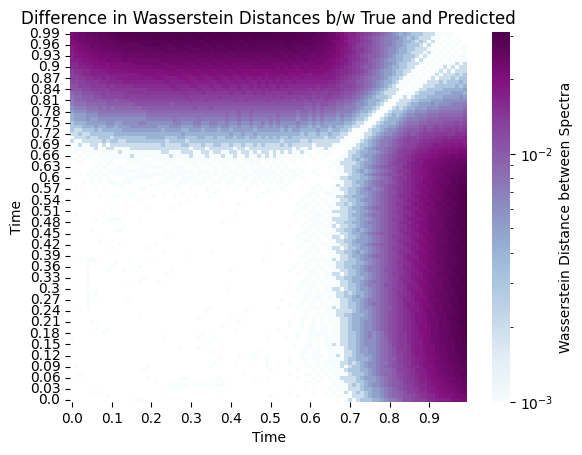

In [ ]:
plot_wasserstein(y_true, all_preds[500000], domain_len=2, num_x=201)

### Diffusion Equation

#### Generating True Solution

In [ ]:
# set up the problem
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, j=1)
    dy_xx = dde.grad.hessian(y, x, j=0)
    return (
        dy_t
        - dy_xx
        + tf.exp(-x[:, 1:])
        * (tf.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * tf.sin(np.pi * x[:, 0:1]))
    )

def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])


geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0.5, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=40,
    num_boundary=20,
    num_initial=10,
    solution=func,
    num_test=10000,
)

In [ ]:
def gen_testdata():
  full_domain = np.zeros(shape=(25600, 2))
  true_sol = np.zeros(shape=(25600,))
  for time_step in range(100):
    time = time_step * .01
    x = geom.uniform_points(256, True)
    t = np.full(256, time)
    x = np.hstack((x, t.reshape(-1, 1)))

    start = int(256 * time * 100)
    end = start + 256
    full_domain[start:end] = x

    ground_truth = np.exp(-time) * np.sin(np.pi * x[:, 0])
    true_sol[start:end] = ground_truth
  
  return full_domain, true_sol

In [ ]:
# compare the true solution with the predicted solution
X, y_true = gen_testdata()

with open('long_model_preds_diffusion.pkl', 'rb') as f:
    all_preds = pickle.load(f)

#### Plotting Wasserstein Distance

<ipython-input-157-8538fd482480>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  true_dists = true_dists.pivot("time_one", "time_two", "value")
<ipython-input-157-8538fd482480>:18: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pred_dists = pred_dists.pivot("time_one", "time_two", "value")


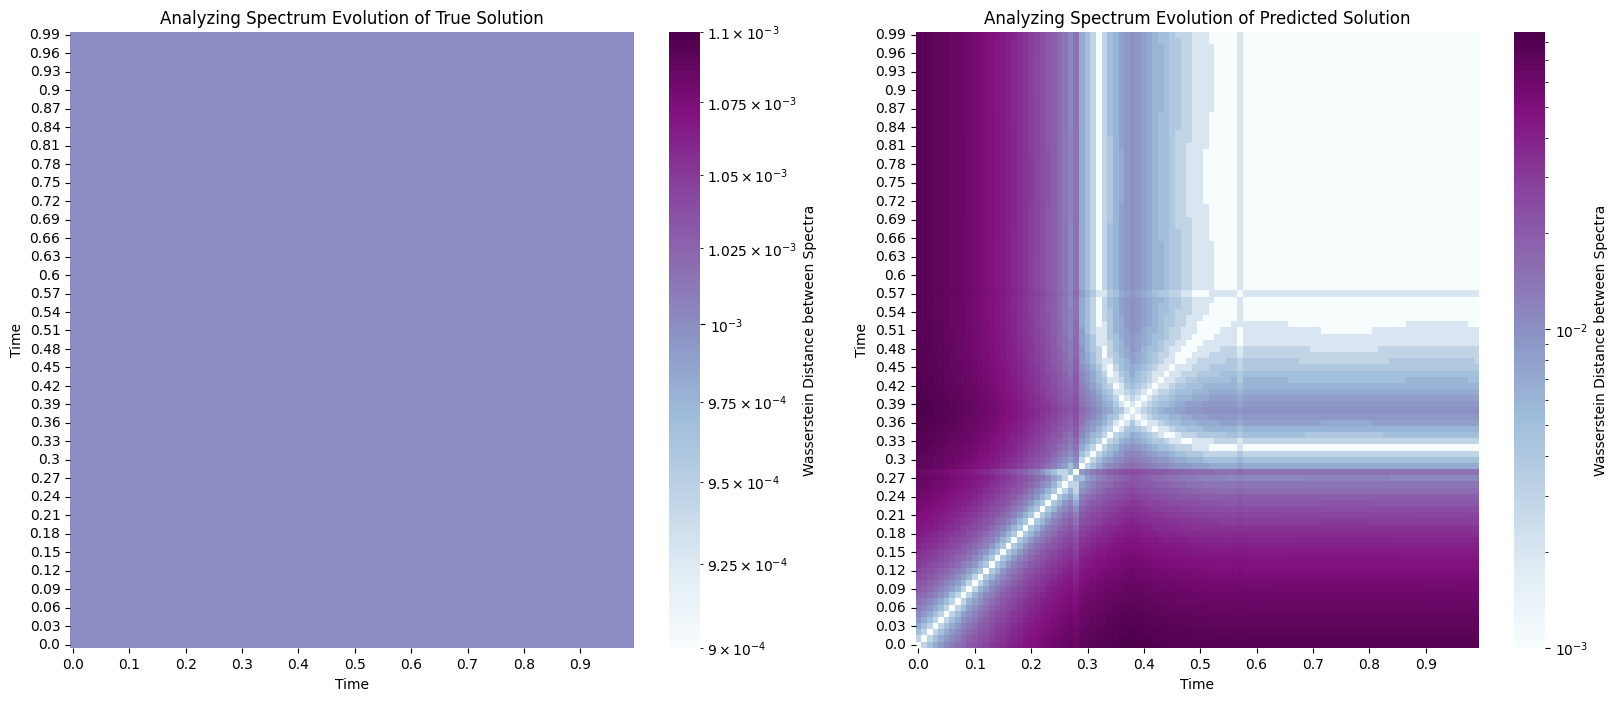

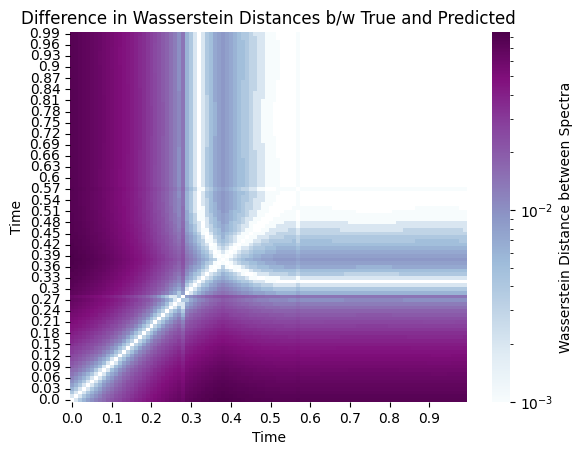

In [ ]:
plot_wasserstein(y_true, all_preds[500000], domain_len=2, num_x=256)

### Diffusion-Reaction Equation

#### Generating True Solution

In [ ]:
# set up the problem

def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    d = 1
    return (
        dy_t
        - d * dy_xx
        - tf.exp(-x[:, 1:])
        * (
            3 * tf.sin(2 * x[:, 0:1]) / 2
            + 8 * tf.sin(3 * x[:, 0:1]) / 3
            + 15 * tf.sin(4 * x[:, 0:1]) / 4
            + 63 * tf.sin(8 * x[:, 0:1]) / 8
        )
    )

def func(x):
    return np.exp(-x[:, 1:]) * (
        np.sin(x[:, 0:1])
        + np.sin(2 * x[:, 0:1]) / 2
        + np.sin(3 * x[:, 0:1]) / 3
        + np.sin(4 * x[:, 0:1]) / 4
        + np.sin(8 * x[:, 0:1]) / 8
    )


geom = dde.geometry.Interval(-np.pi, np.pi)
timedomain = dde.geometry.TimeDomain(0, 0.5)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# define the boundary and initial conditions
bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)

data = dde.data.TimePDE(
    geomtime, pde, [bc, ic], num_domain=320, num_boundary=20,
    num_initial=10, solution=func, num_test=10000)

In [ ]:
def gen_testdata():
  full_domain = np.zeros(shape=(25600, 2))
  true_sol = np.zeros(shape=(25600,))
  for time_step in range(100):
    time = time_step * .01
    x = geom.uniform_points(256, True)
    t = np.full(256, time)
    x = np.hstack((x, t.reshape(-1, 1)))

    start = int(256 * time * 100)
    end = start + 256
    full_domain[start:end] = x

    ground_truth = np.exp(-time) * (np.sin(x[:, 0]) + np.sin(2*x[:, 0])/2 + np.sin(3*x[:, 0])/3 + np.sin(4*x[:, 0])/4 + np.sin(8*x[:, 0])/8)
    true_sol[start:end] = ground_truth
  
  return full_domain, true_sol

In [ ]:
import pickle

# compare the true solution with the predicted solution
X, y_true = gen_testdata()

with open('model_preds_diffusion_reaction.pkl', 'rb') as f:
    all_preds = pickle.load(f)

#### Plotting Wasserstein Distance

<ipython-input-157-8538fd482480>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  true_dists = true_dists.pivot("time_one", "time_two", "value")
<ipython-input-157-8538fd482480>:18: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pred_dists = pred_dists.pivot("time_one", "time_two", "value")


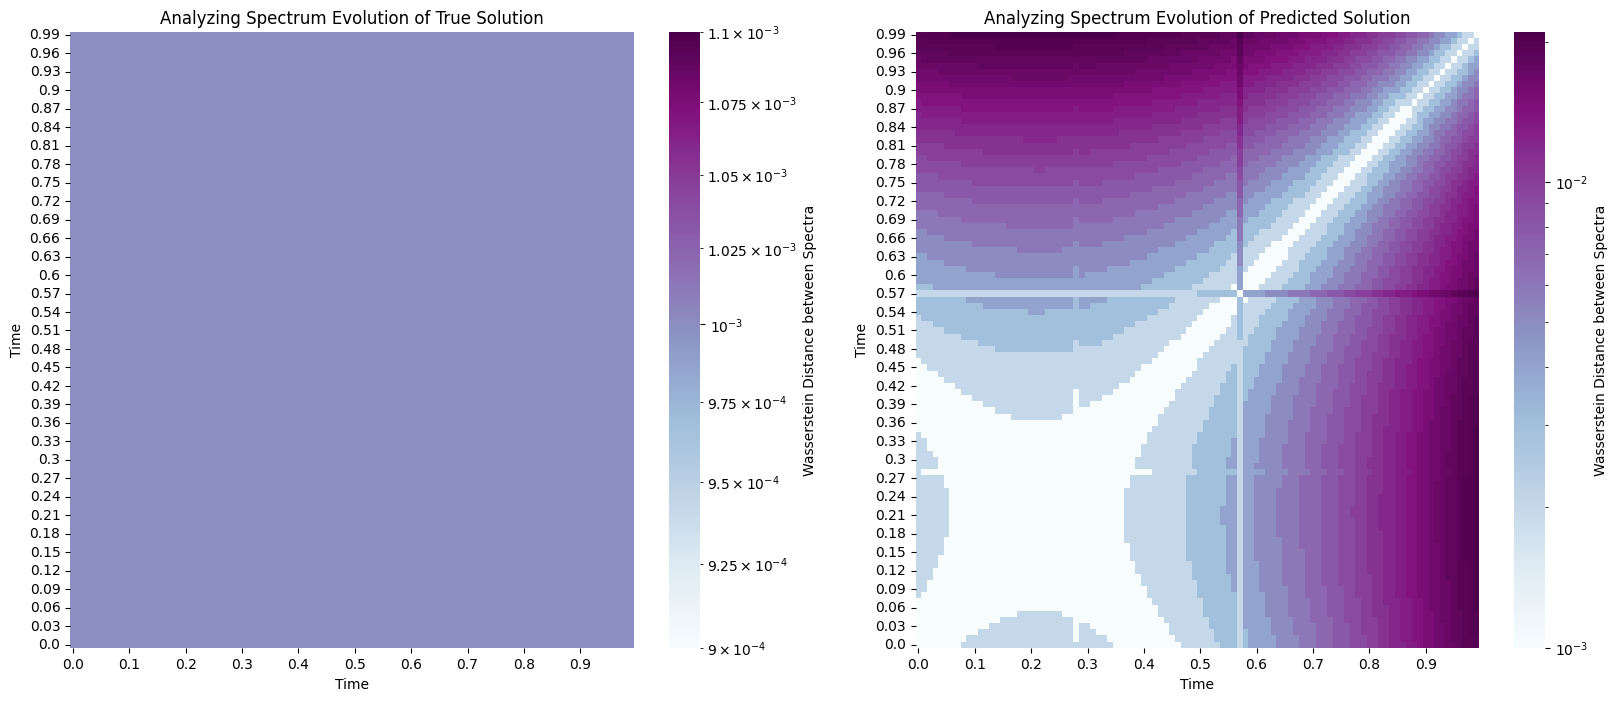

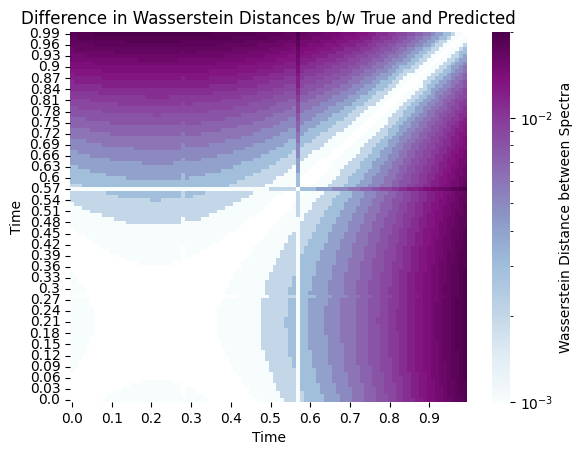

In [ ]:
plot_wasserstein(y_true, all_preds[500000], domain_len=2, num_x=256)

### Relationship with L2 Error